# 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

import datetime

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. STEP 01 - DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = map(snakecase, cols_old)

df1.columns = cols_new

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance
# preenchendo valores NA com valor bem acima do máximo
# se a distância é zero, pode ser uma loja muito distante ou não ter competição
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                math.isnan(x['competition_open_since_month']) else 
                                                x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                math.isnan(x['competition_open_since_year']) else 
                                                x['competition_open_since_year'], axis=1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if 
                                     math.isnan(x['promo2_since_week']) else 
                                     x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if 
                                     math.isnan(x['promo2_since_year']) else 
                                     x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
             9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                             1 if x['month_map'] in 
                                                             x['promo_interval'].split(',') else 0, axis=1)

In [17]:
df1.sample(5).T

,645388,1016662,462117,763476,893811
store,589,568,178,487,367
day_of_week,6,2,2,5,7
date,2013-11-30 00:00:00,2013-01-01 00:00:00,2014-05-13 00:00:00,2013-08-16 00:00:00,2013-04-21 00:00:00
sales,3840,0,7786,7459,0
customers,442,0,809,745,0
open,1,0,1,1,0
promo,0,0,0,1,0
state_holiday,0,a,0,0,0
school_holiday,0,1,0,0,0
store_type,a,d,d,d,d


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


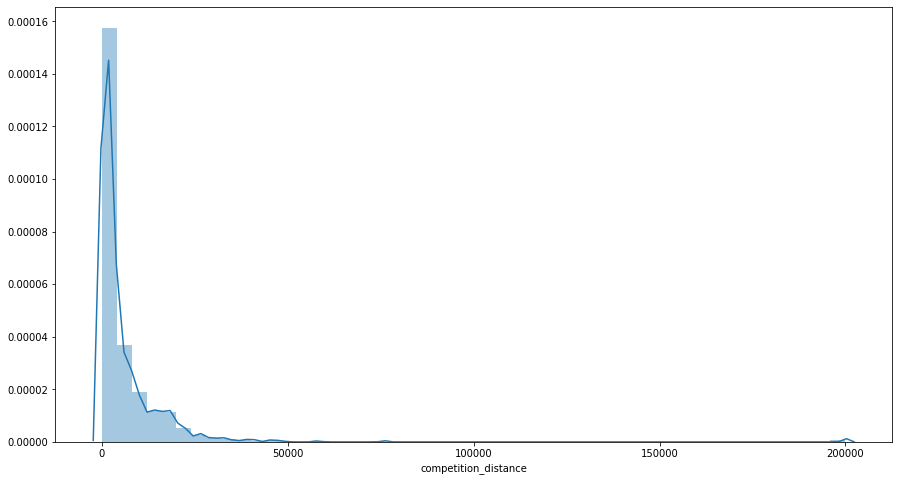

In [35]:
plt.figure(figsize=(15,8))
sns.distplot(df1['competition_distance']);

### 1.7.2. Categorical Attributes

In [30]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

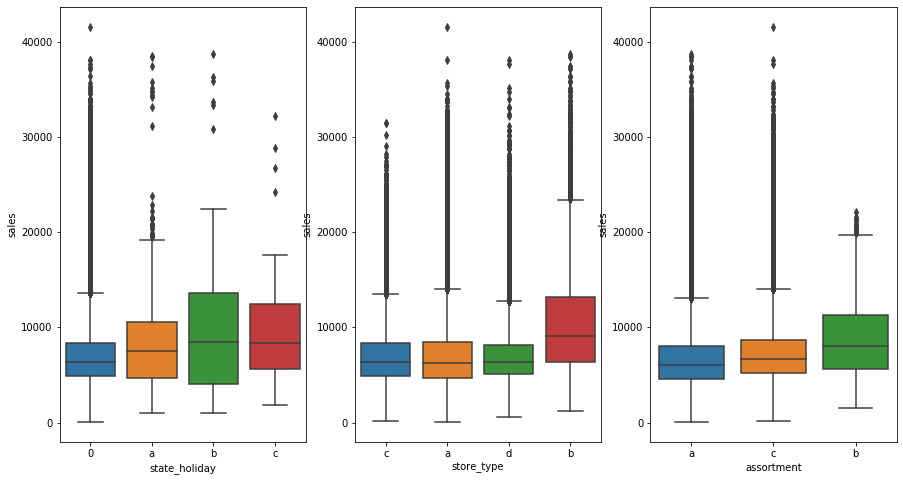

In [36]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.figure(figsize=(15,8))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

In [39]:
# Salvando modificações para carregar na próxima etapa
df1.to_csv('data/df_step01.csv', index=False)

# 2.0 STEP 02 - FEATURE ENGINEERING

In [2]:
# Carregando dados tratados da etapa anterior
df2 = pd.read_csv('data/df_step01.csv', low_memory=False, parse_dates=['date'])

## 2.1. Mind Map Hypothesis

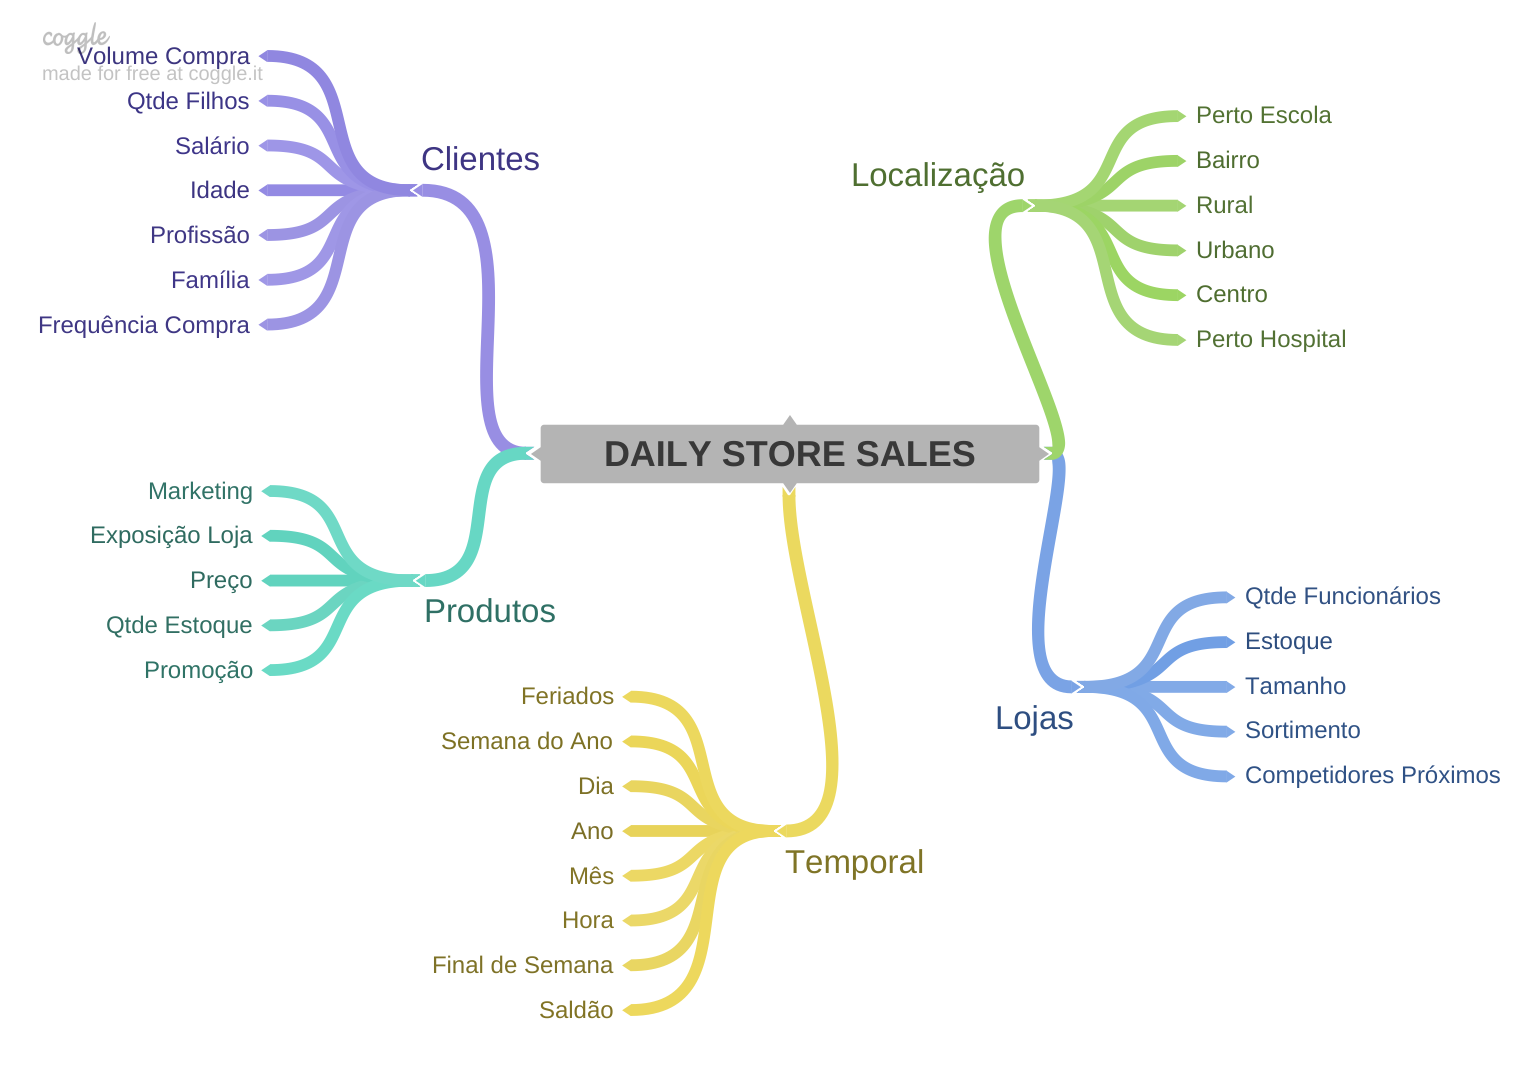

In [3]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.  
**2.** Lojas com maior capacidade de estoque deveriam vender mais.  
**3.** Lojas com maior porte deveriam vender mais.  
**4.** Lojas com maior sortimento deveriam vender mais.  
**5.** Lojas com competidores mais próximos deveriam vender menos.  
**6.** Lojas com competidores à mais tempo deveriam vendem mais.  

### 2.2.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.  
**2.** Lojas com maior exposição de produto deveriam vender mais.  
**3.** Lojas com produtos com preço menor deveriam vender mais.  
**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.  
**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**7.** Lojas com mais dias de promoção deveriam vender mais.  
**8.** Lojas com mais promoções consecutivas deveriam vender mais.  

### 2.2.3. Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**2.** Lojas deveriam vender mais ao longo dos anos.  
**3.** Lojas deveriam vender mais no segundo semestre do ano.  
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**5.** Lojas deveriam vender menos aos finais de semana.  
**6.** Lojas deveriam vender menos durante os feriados escolares.  

## 2.3. Final Hypothesis List

**1.** Lojas com maior sortimento deveriam vender mais.  
**2.** Lojas com competidores mais próximos deveriam vender menos.  
**3.** Lojas com competidores à mais tempo deveriam vendem mais.  
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**5.** Lojas com mais dias de promoção deveriam vender mais.  
**7.** Lojas com mais promoções consecutivas deveriam vender mais.  
**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**9.** Lojas deveriam vender mais ao longo dos anos.  
**10.** Lojas deveriam vender mais no segundo semestre do ano.  
**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**12.** Lojas deveriam vender menos aos finais de semana.  
**13.** Lojas deveriam vender menos durante os feriados escolares.  

## 2.4. Feature Engineering

In [4]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                                    datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                  'easter_holiday' if x == 'b' else 
                                                  'christmas' if x == 'c' else 'regular_day')

In [5]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [6]:
# Salvando modificações para carregar na próxima etapa
df2.to_csv('data/df_step02.csv', index=False)

# 3.0 STEP 03 - FEATURE FILTERING

In [7]:
# Carregando dados tratados da etapa anterior
df3 = pd.read_csv('data/df_step02.csv', low_memory=False, parse_dates=['date'])

In [9]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Rows Filtering

In [10]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [11]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [12]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [13]:
# Salvando modificações para carregar na próxima etapa
df3.to_csv('data/df_step03.csv', index=False)

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [4]:
# Carregando dados tratados da etapa anterior
df4 = pd.read_csv('data/df_step03.csv', low_memory=False, parse_dates=['date'])

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

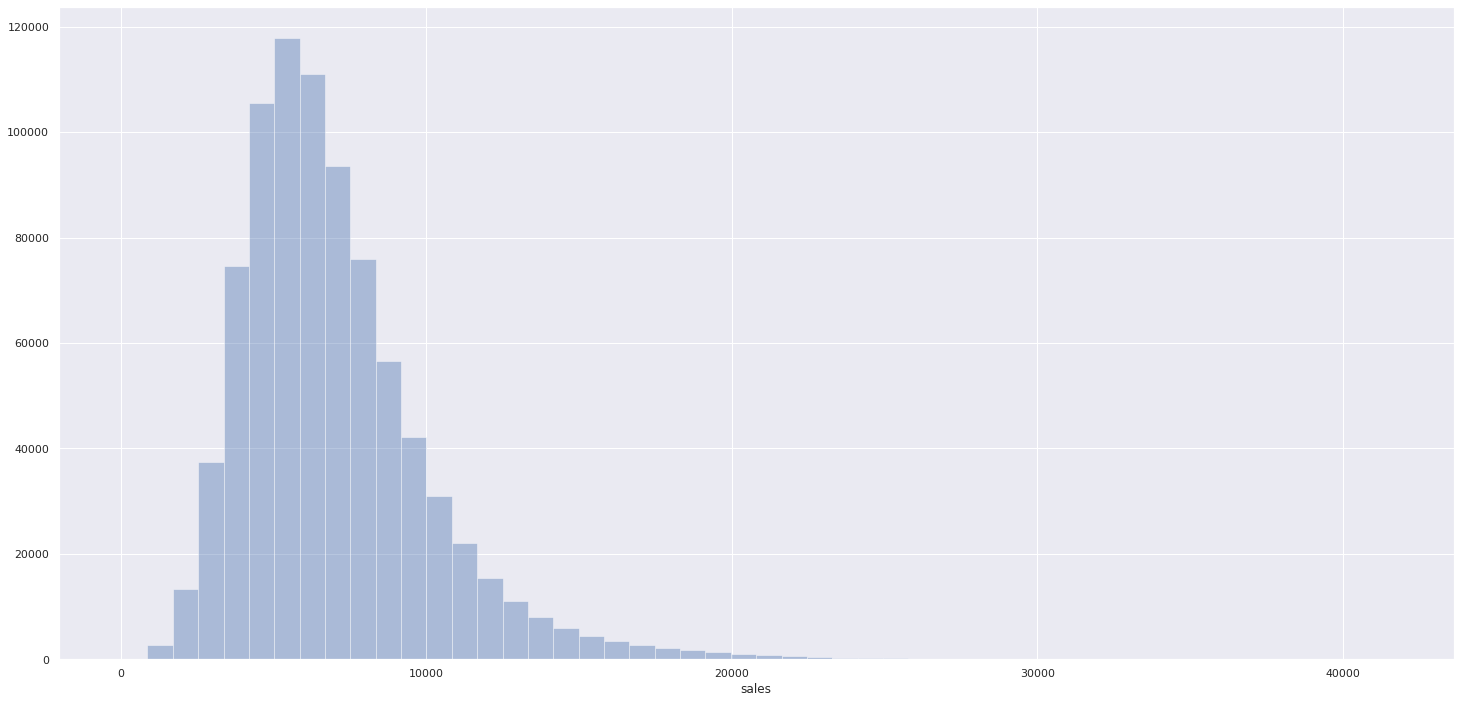

In [5]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2. Numerical Variable

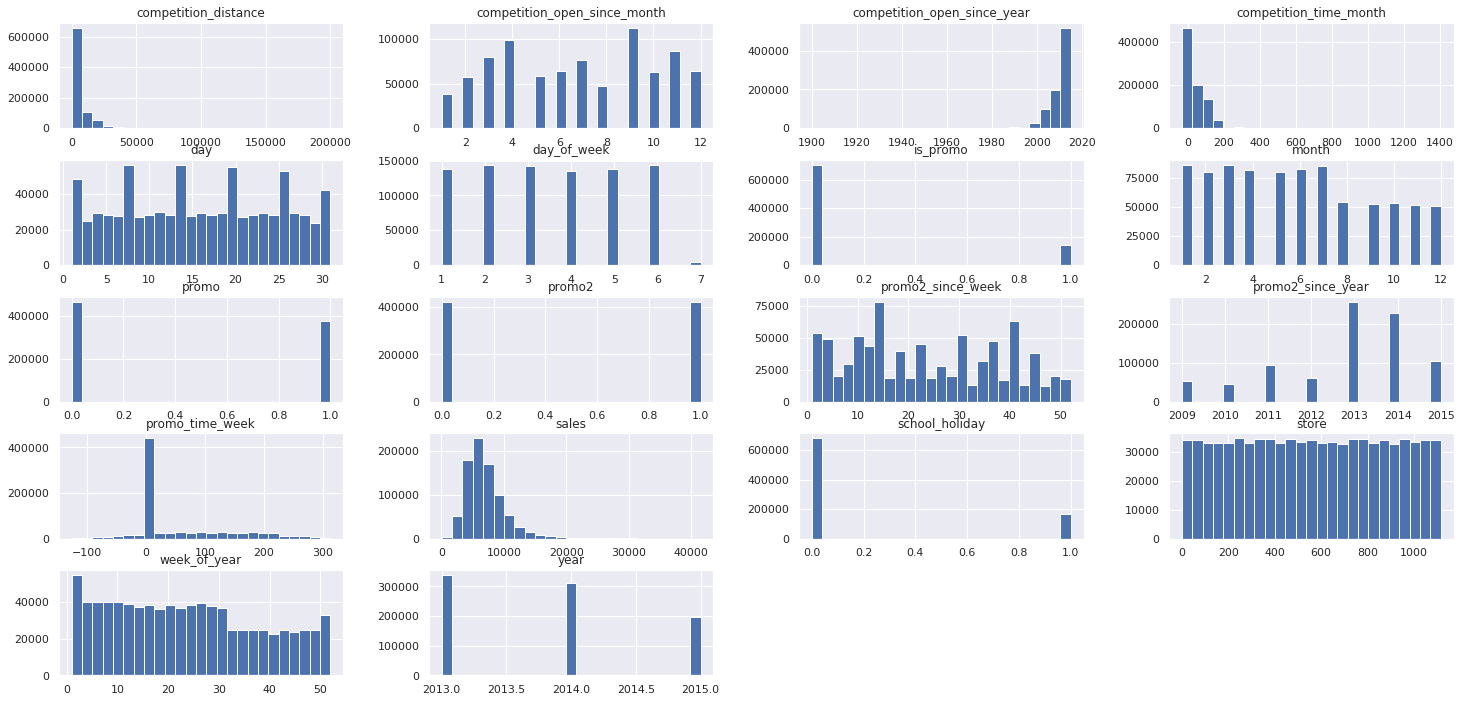

In [6]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [7]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

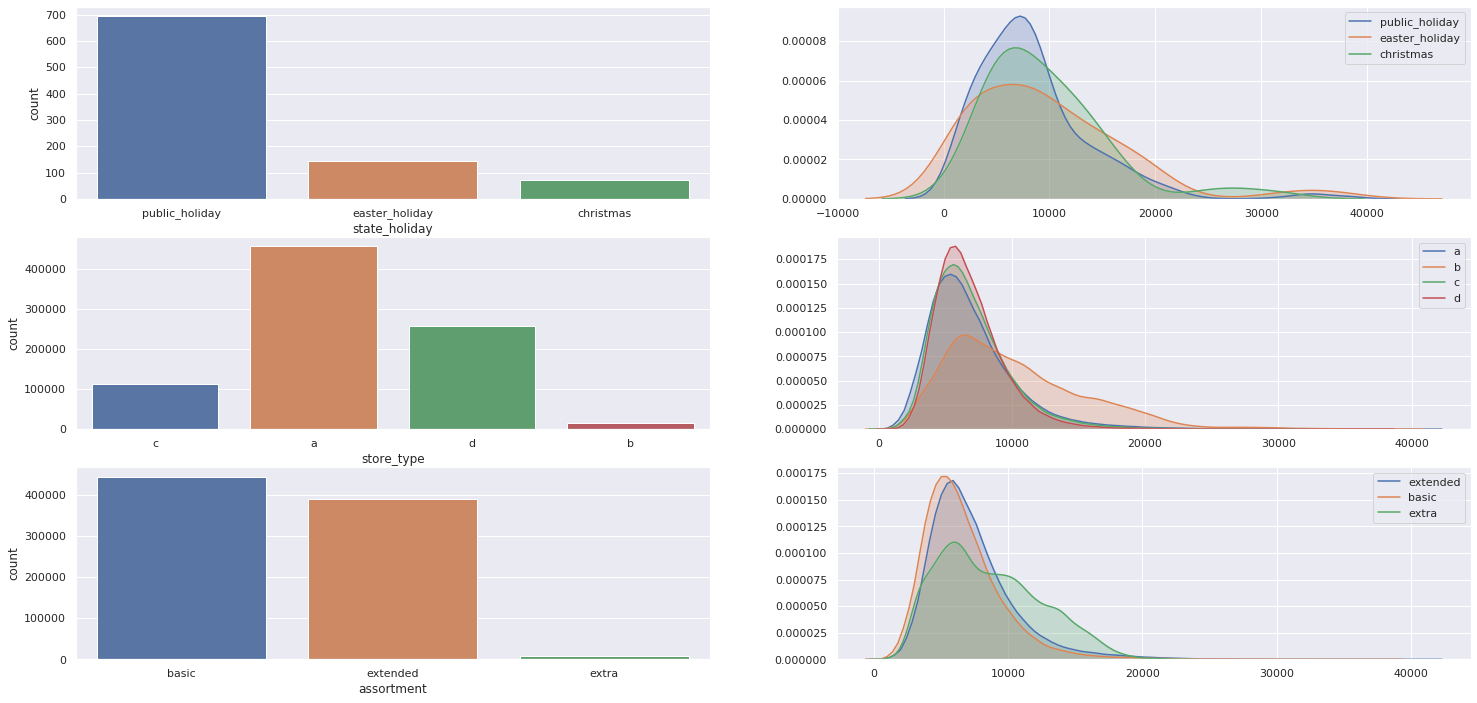

In [8]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem MENOS.

#### Raciocínio

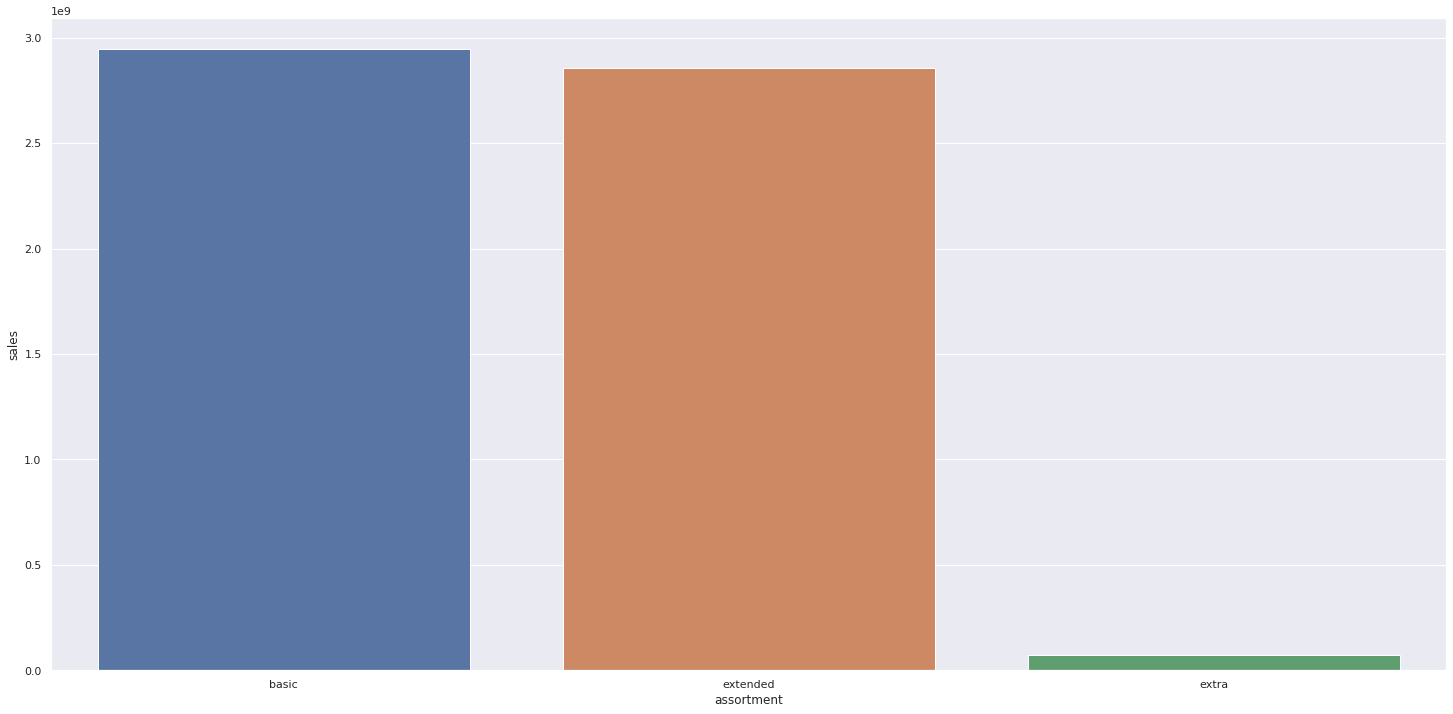

In [10]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

Será que houve alguma mudança de comportamento ao decorrer do tempo que indique o baixo volume de vendas do sortimento tipo extra?  
Vamos adicionar a coluna 'year_week' à análise para checar.

In [12]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


Cada valor de year_week (nossa granularidade) possui 3 categorias. Logo é interessante alterar essa forma de visualização fazendo um pivô da tabela em relação a year_week.

In [17]:
# pivot
aux2.pivot(index='year_week', columns='assortment', values='sales').head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


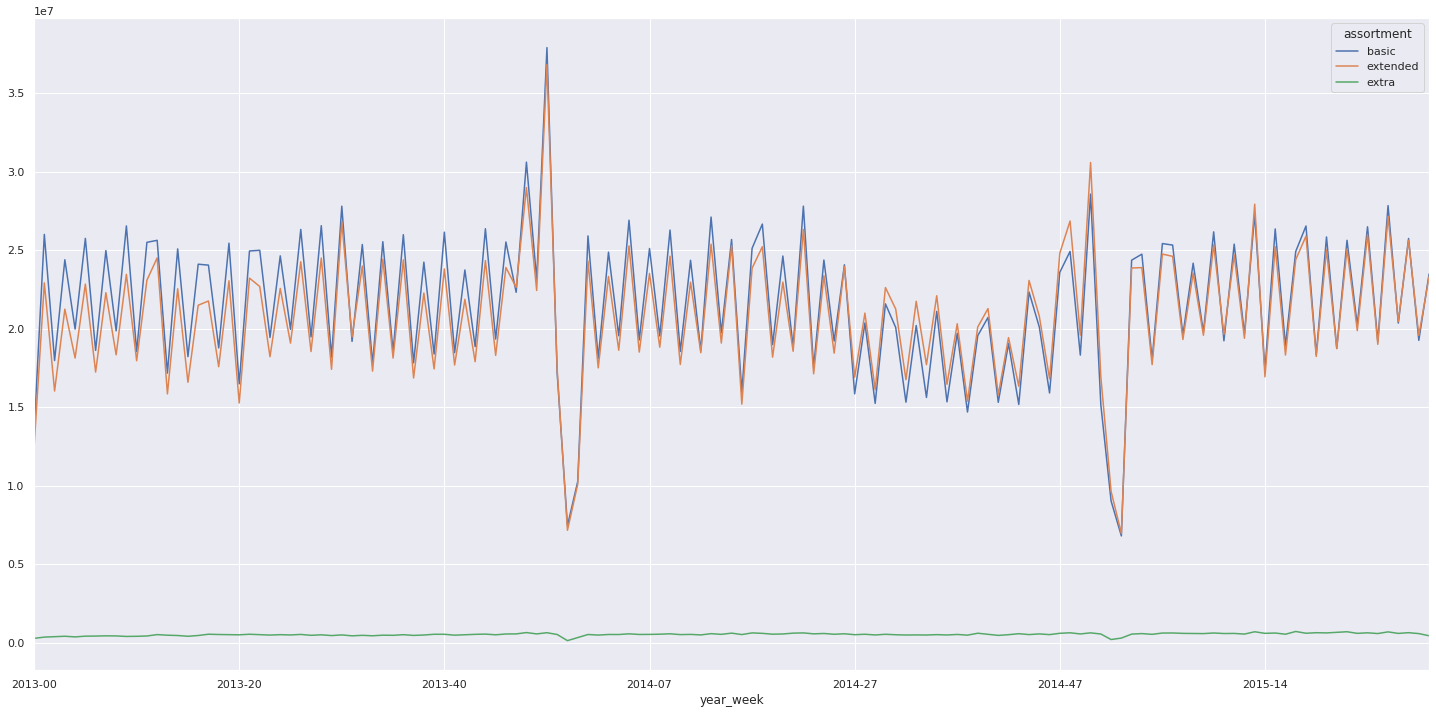

In [18]:
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

O volume de vendas para o mix de produtos básicos e estendidos são praticamentes iguais, destoando bastante das lojas com mix de produtos extra.  
Essa dirença é tão grande que os básicos e estendidos puxam a escala para cima.  
O ideal seria olhar para a linha do extra apenas para observar se há algum comportamento diferente ou se é praticamente um comportamento linear.

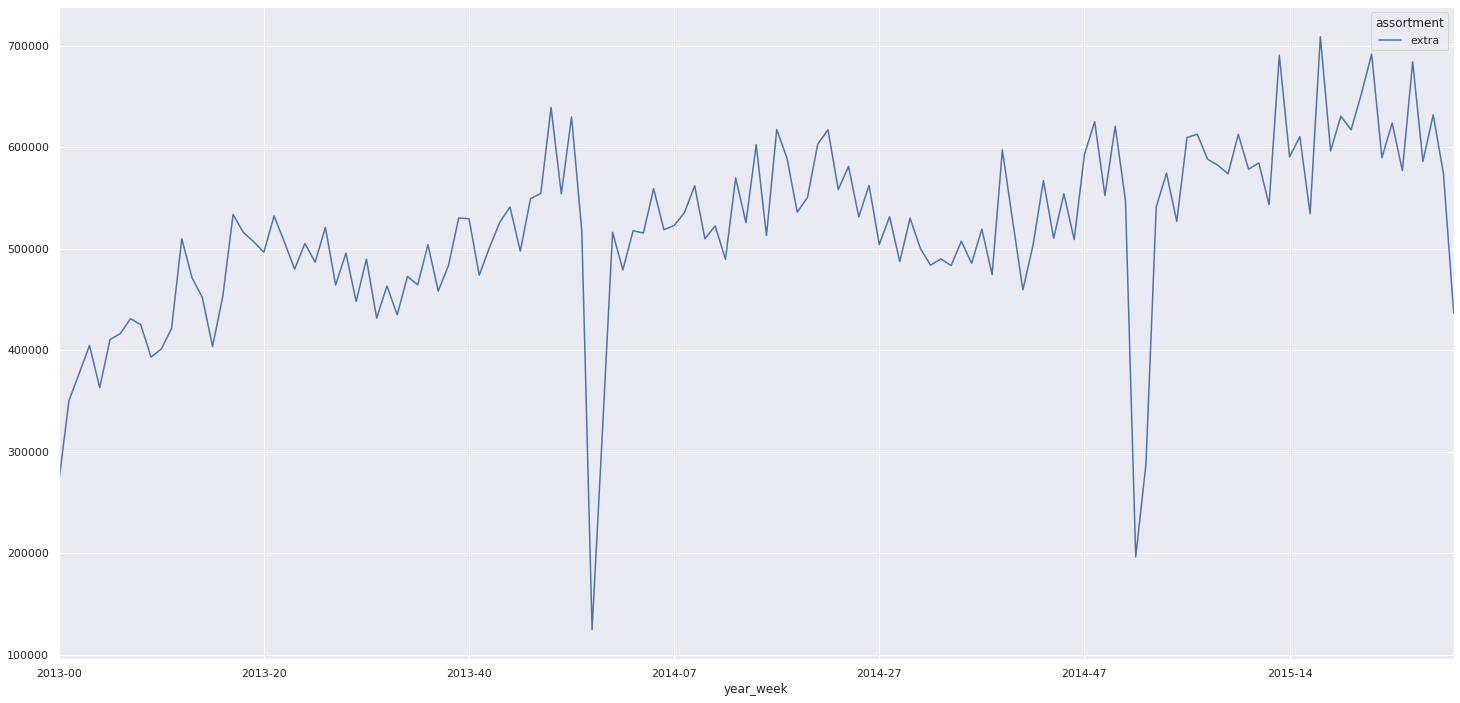

In [20]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

Podemos ver que há um comportamento na categoria de "assortment extra" e não é linear como parecia.  
Isso mostra que quando temos valores muito discrepantes entre uma categoria e outra, o idel é analisar a categoria separada.  
Logo, essa se apresenta como uma variável importante para o apresendizado do modelo devido a diferença de comportamento entre as categorias.

#### Código limpo

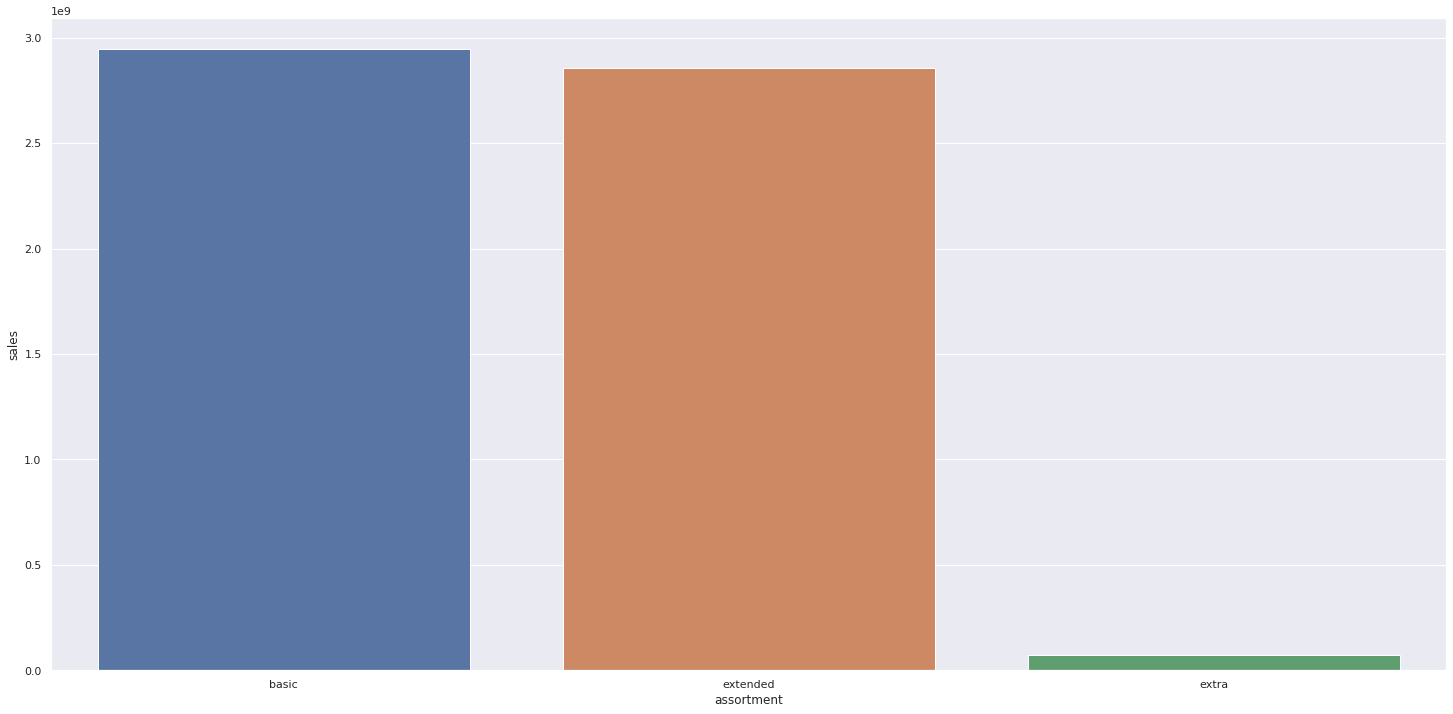

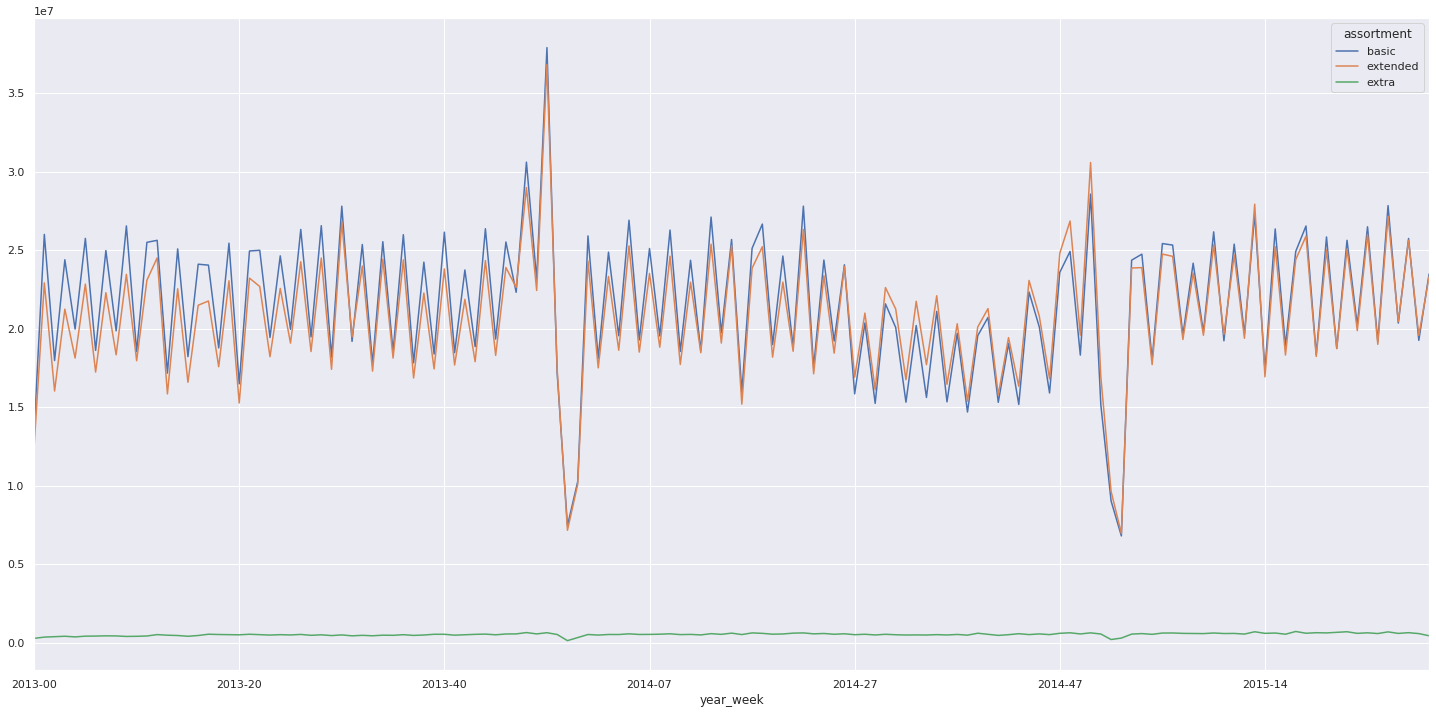

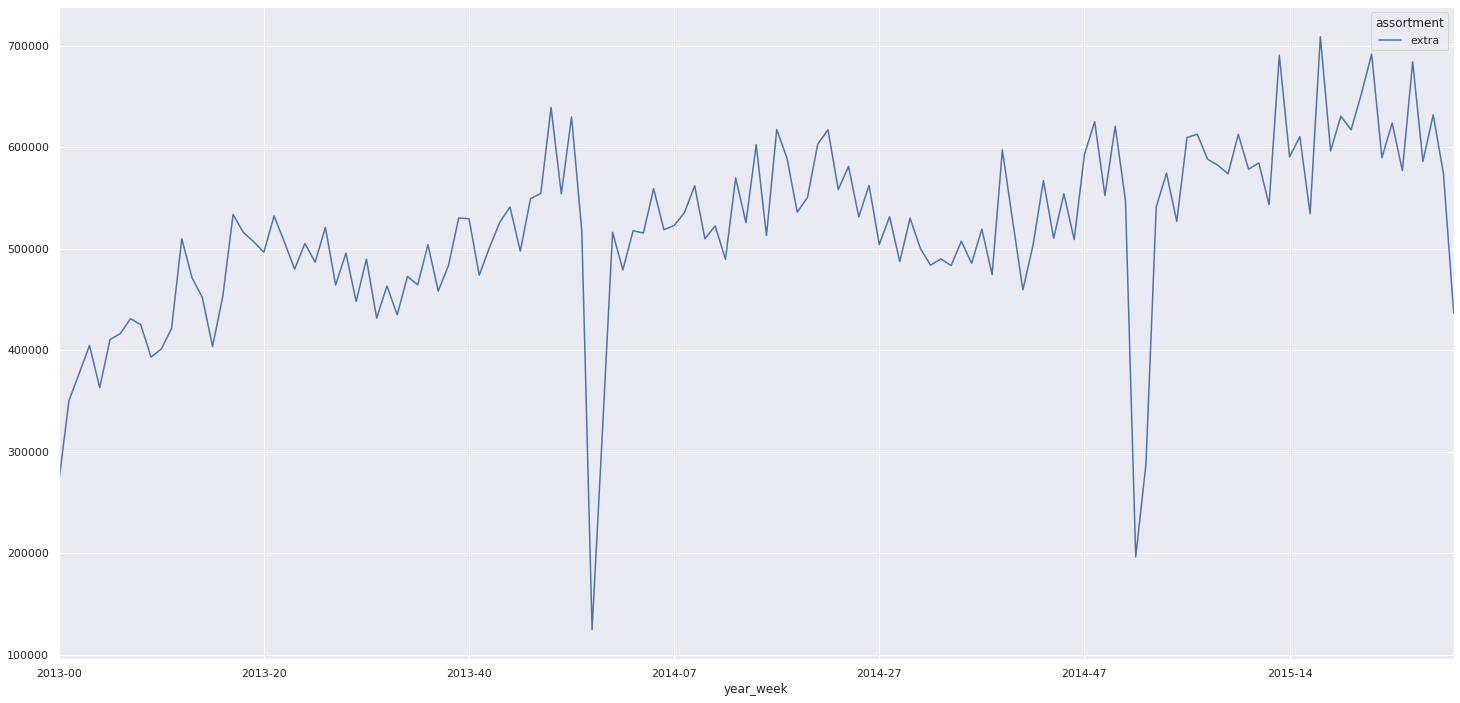

In [22]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

#### Raciocínio

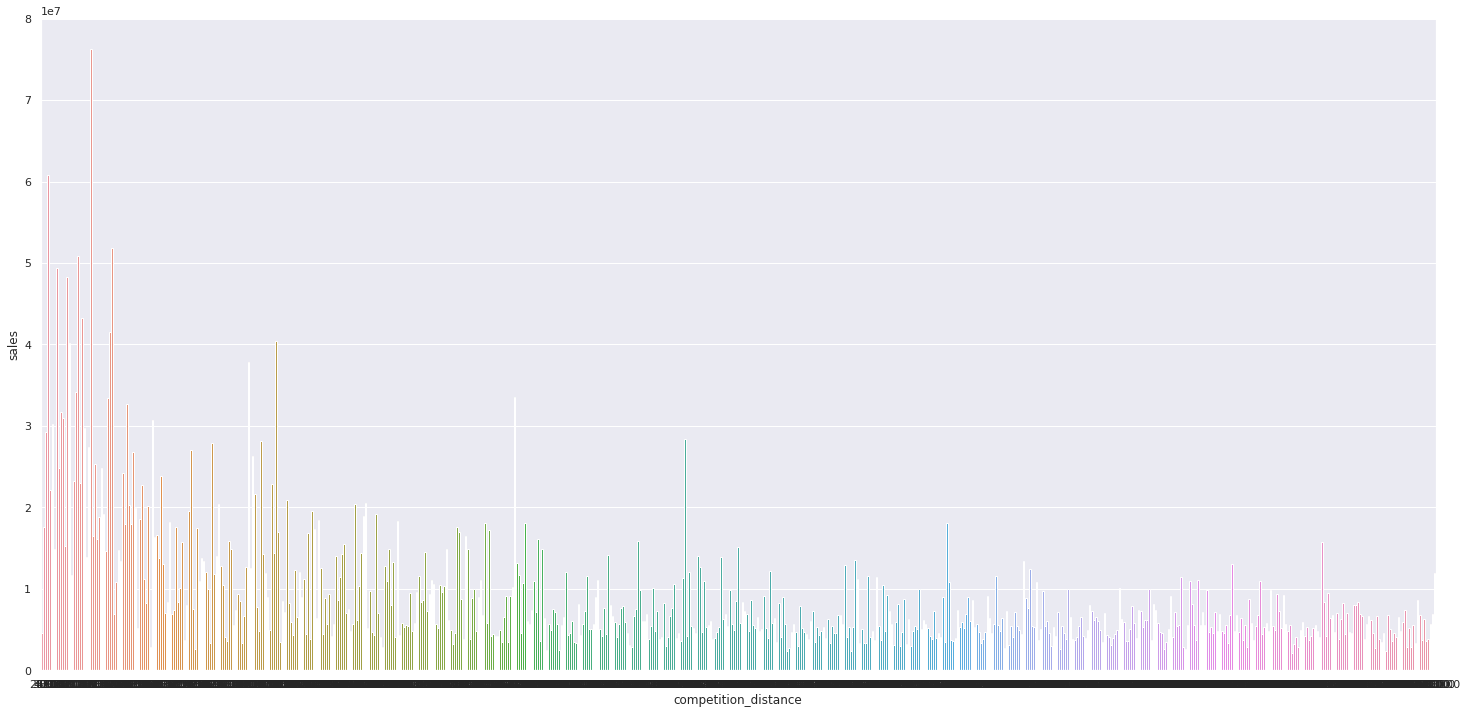

In [23]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance', y='sales', data=aux1);

Avaliar as vendas agrupadas pela distância dos competidores, torna o resultado muito granular pois conta item a item. Para analisar melhor, podemos criar grupos (ranges de valores) para as distâncias.

In [27]:
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
235,2890.0,14897828,"(2000, 3000]"
261,3290.0,11066811,"(3000, 4000]"
487,10310.0,5466800,"(10000, 11000]"
269,3390.0,5921634,"(3000, 4000]"


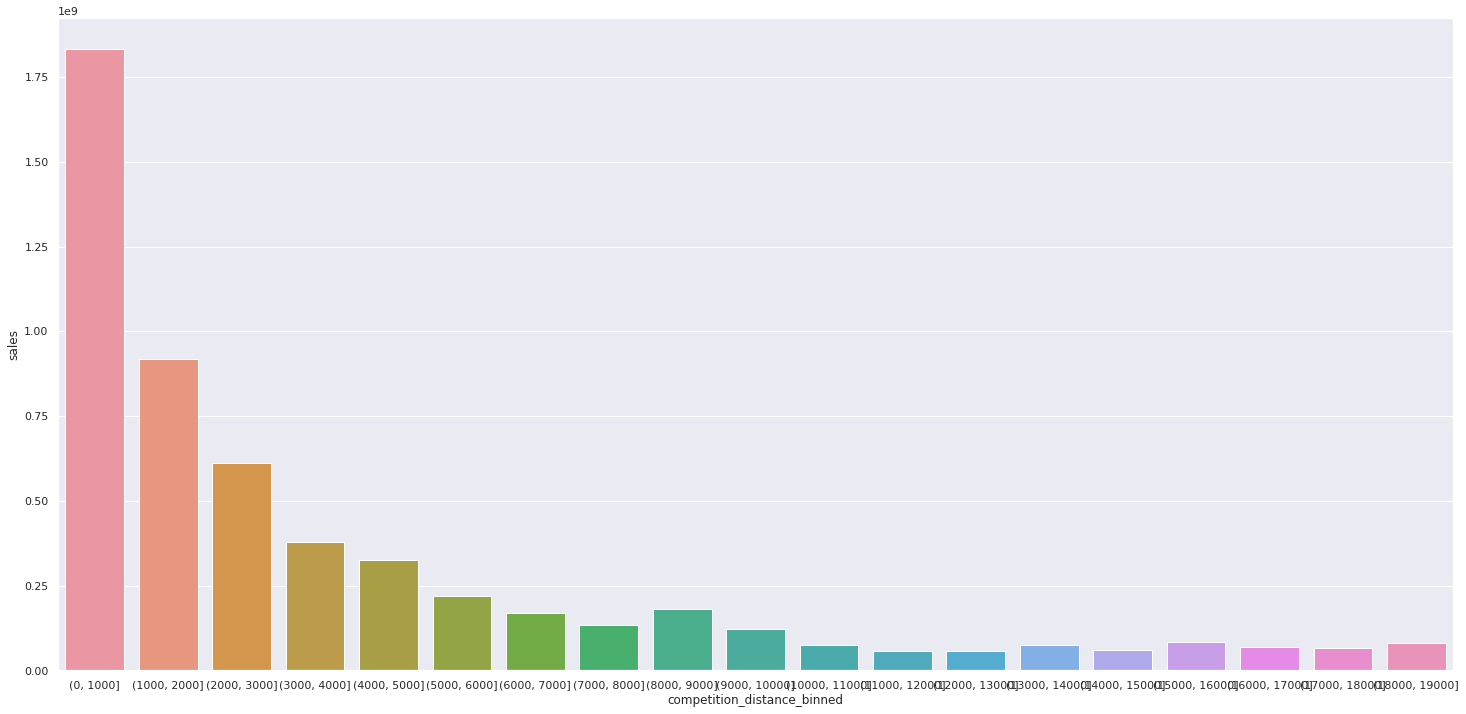

In [28]:
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

O gráfico acima mostra o oposto da hipótese, em que as lojas que possuem competidores mais próximos na verdade, vendem mais.

Outra opção para visualizar dados muito granulares é através de um gráfico de dispersão.

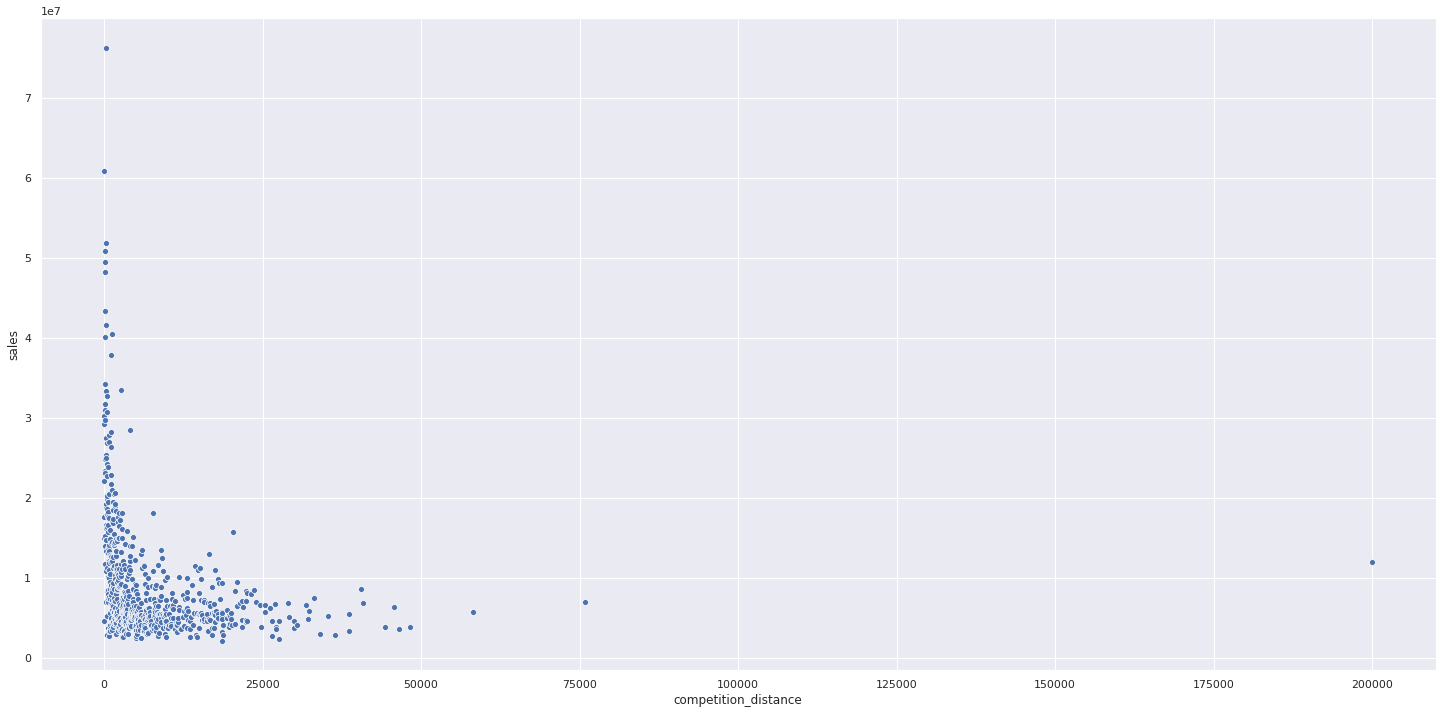

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

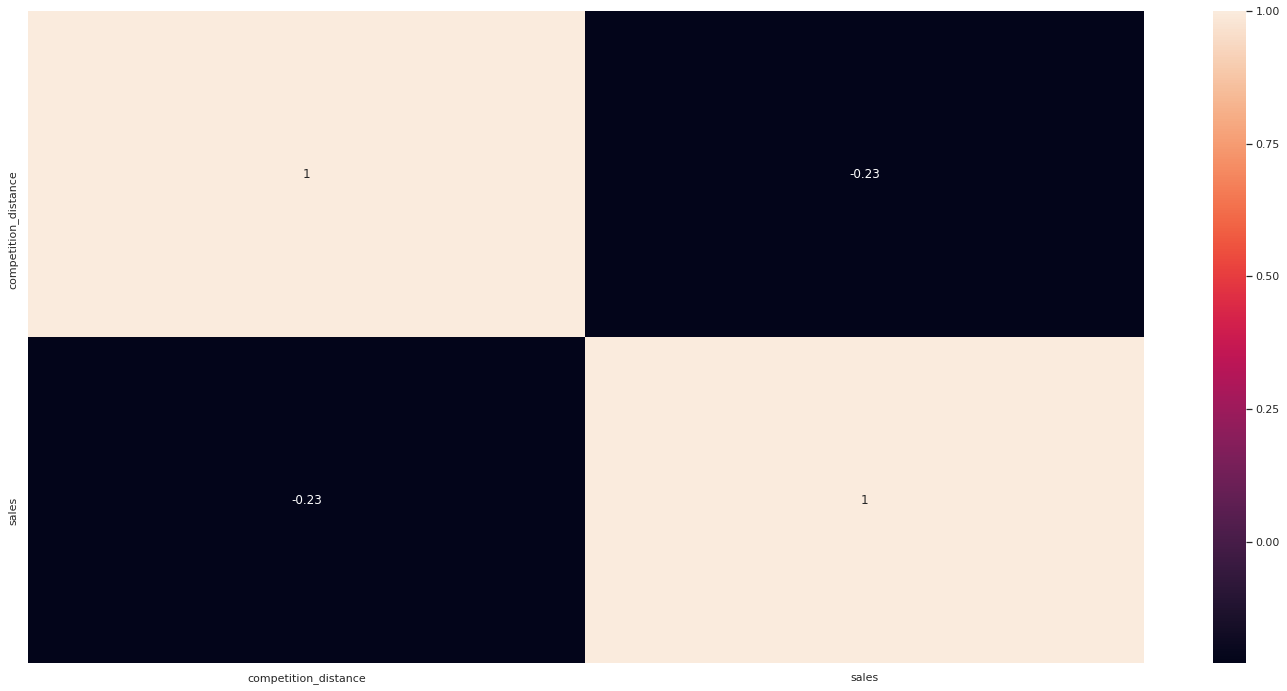

In [30]:
# verificando a correlação
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### Código limpo

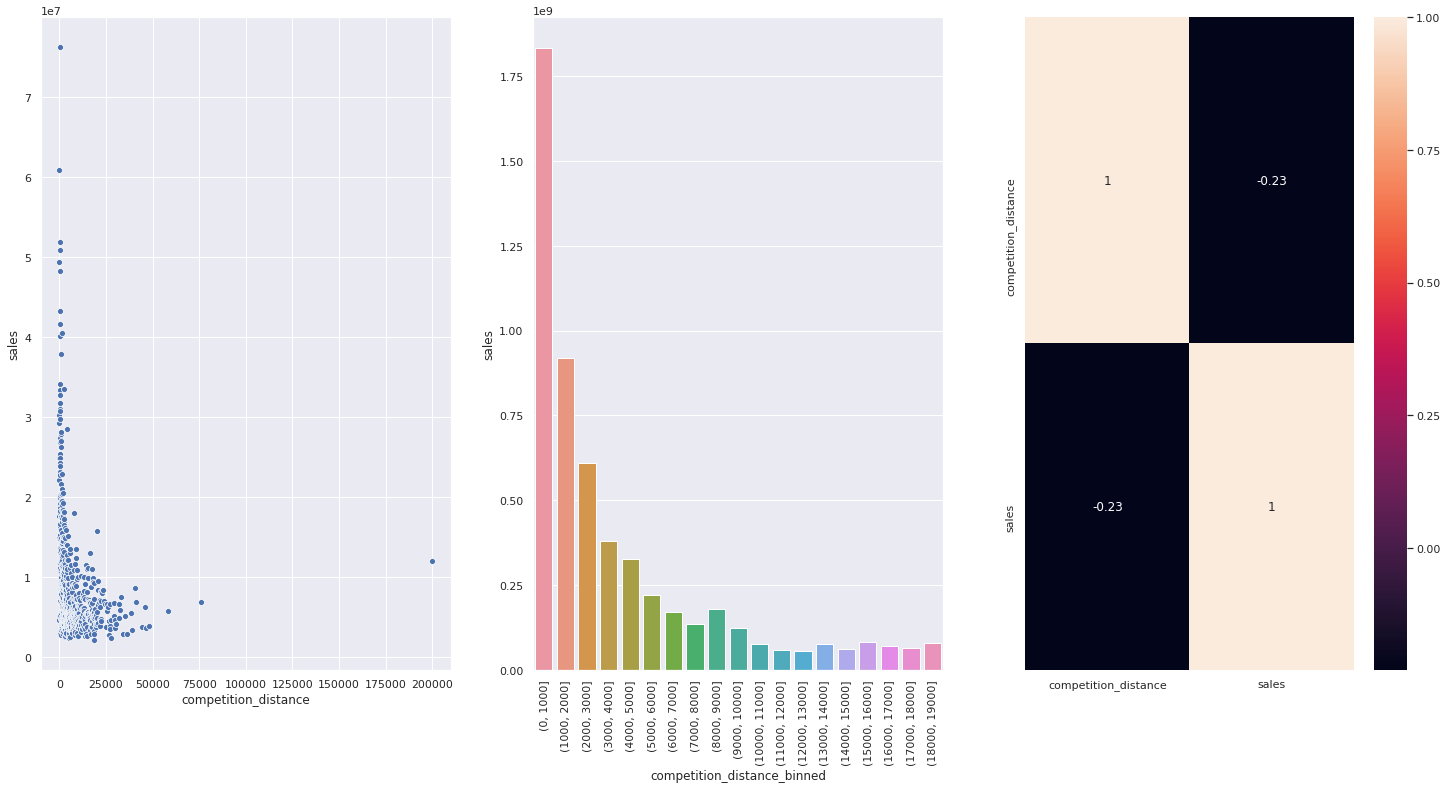

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

#### Raciocínio

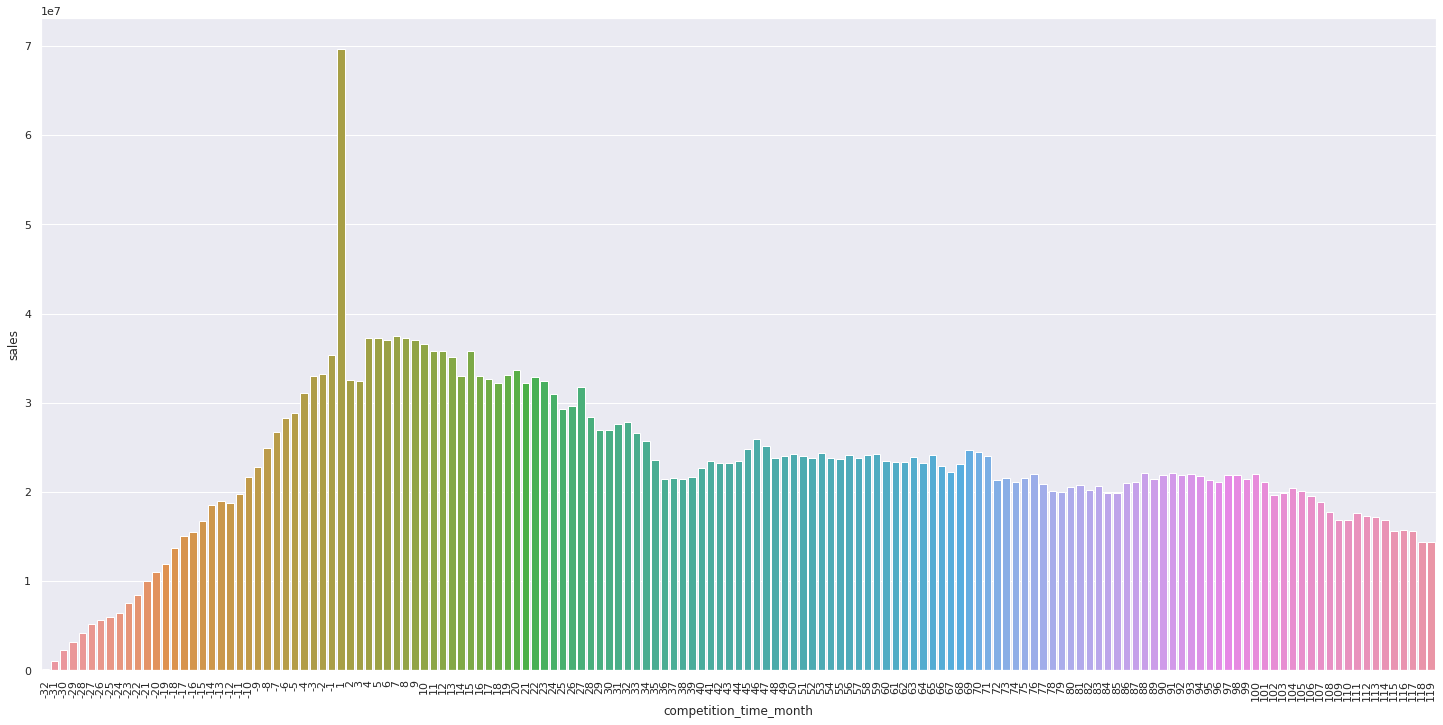

In [35]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# filtro para diminuir granularidade
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

Os números negativos indicam que os competidores chegaram depois da data dos dados de venda e os positivos são referentes aos competidores que chegaram após os dados de venda.  
E é mostrado que o volume de vendas aumenta quando mais próximo de zero, ou seja, quanto mais recente é a chegada do competidor, maior a venda.

#### Código limpo

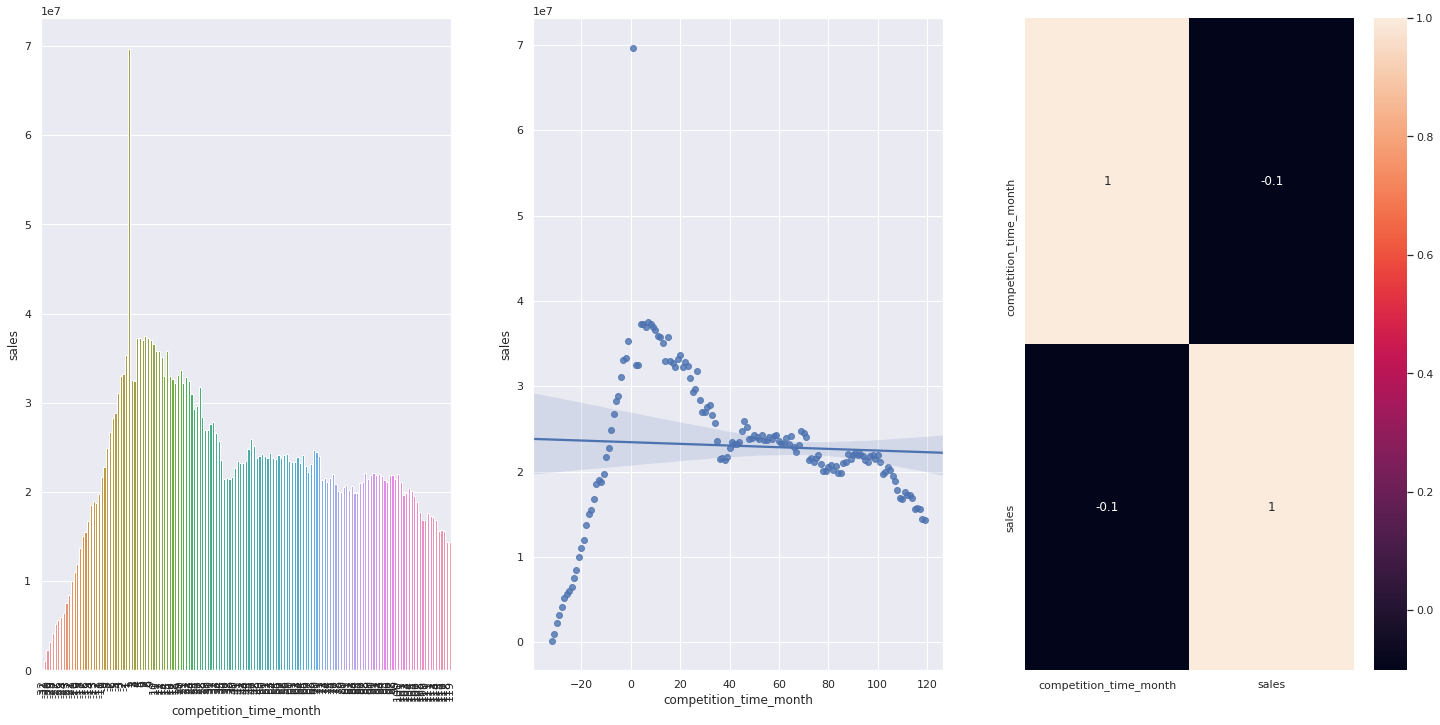

In [36]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# filtro para diminuir granularidade
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3. Multivariate Analysis